In [1]:
from dataset_creation import *

In [2]:

df_p1 = data_processing('datasets/raw/OhioT1DM/559-ws-training.xml')
df_p2 = data_processing('datasets/raw/OhioT1DM/563-ws-training.xml')
df_p3 = data_processing('datasets/raw/OhioT1DM/570-ws-training.xml')
df_p4 = data_processing('datasets/raw/OhioT1DM/575-ws-training.xml')
df_p5 = data_processing('datasets/raw/OhioT1DM/588-ws-training.xml')
df_p6 = data_processing('datasets/raw/OhioT1DM/591-ws-training.xml')


In [3]:
# List of patient DataFrames
patient_dfs = [df_p1, df_p2, df_p3, df_p4, df_p5, df_p6]
features_to_normalize = ["glu", "glu_d", "glu_t", "hr", "hr_d", "hr_t", "iob"]
normalized_dfs = []

# Process each patient with index tracking
for idx, df_patient in enumerate(patient_dfs, start=1):
    # Create a copy to avoid modifying the original DataFrame
    df_normalized = df_patient.copy()
    
    # Initialize and fit scaler
    scaler = StandardScaler()
    df_normalized[features_to_normalize] = scaler.fit_transform(df_patient[features_to_normalize])
    
    # Save scaler with patient index (e.g., scaler_patient_1.pkl)
    scaler_filename = f'datasets/processed/scaler_patient_{idx}.pkl'
    joblib.dump(scaler, scaler_filename)
    
    # Append normalized data to list
    normalized_dfs.append(df_normalized)

# Combine all patient data
combined_df = pd.concat(normalized_dfs, ignore_index=True)

# Save to CSV
output_file = 'datasets/processed/full-training.csv'
combined_df.to_csv(output_file, index=False)  # Fix: Use combined_df, not df

In [4]:
from dataset_analysis import*

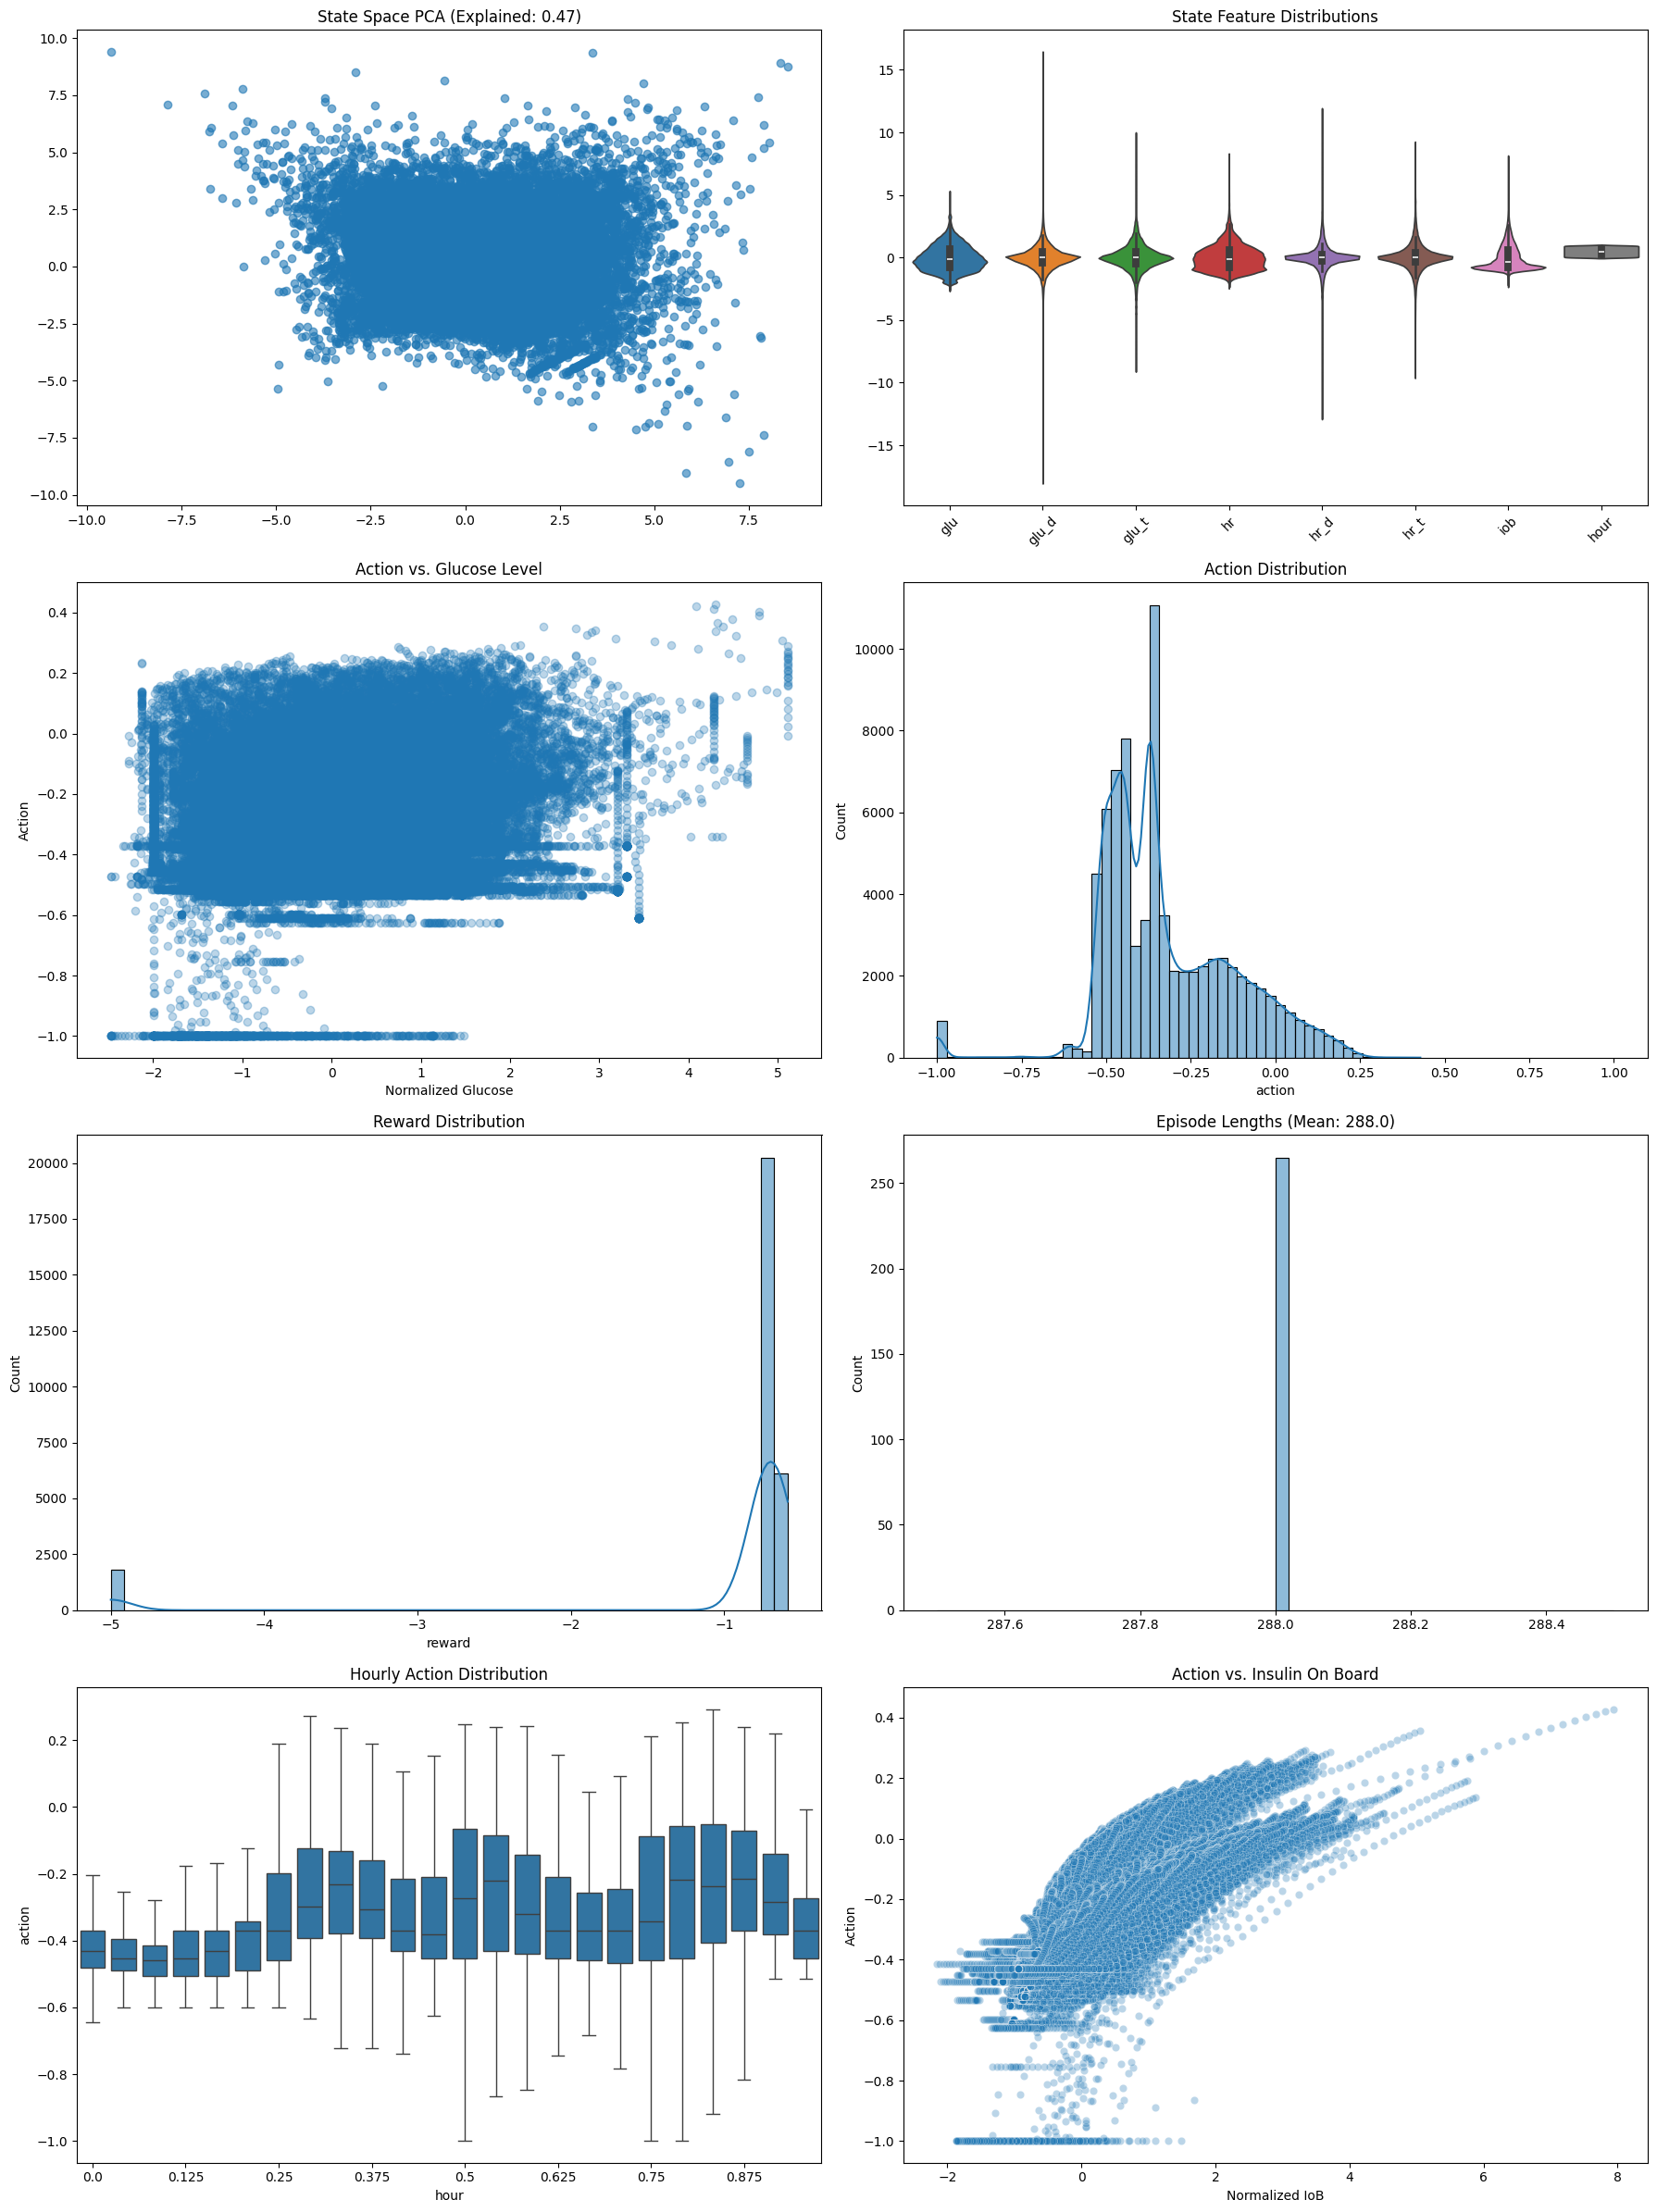


=== Critical Metrics ===

Action Space Statistics:
                  0
min       -1.000000
max        0.428152
mean      -0.318547
std        0.197212
5th %ile  -0.515114
95th %ile  0.054029

Top State-Action Correlations:
action    1.000000
iob       0.802312
glu       0.248709
hour      0.241889
hr        0.166425
Name: action, dtype: float64

Episodes with Extreme Actions (<-0.9): 1.19%
Episodes with No Action (>-0.1): 15.77%

Weakest Hourly Coverage: 3191 samples

Missing States: 0
Missing Actions: 0

Action Value Brackets:
action
<-0.5        0.121900
-0.5:-0.1    0.718535
-0.1:0       0.078964
0:0.5        0.080602
>0.5         0.000000
Name: proportion, dtype: float64


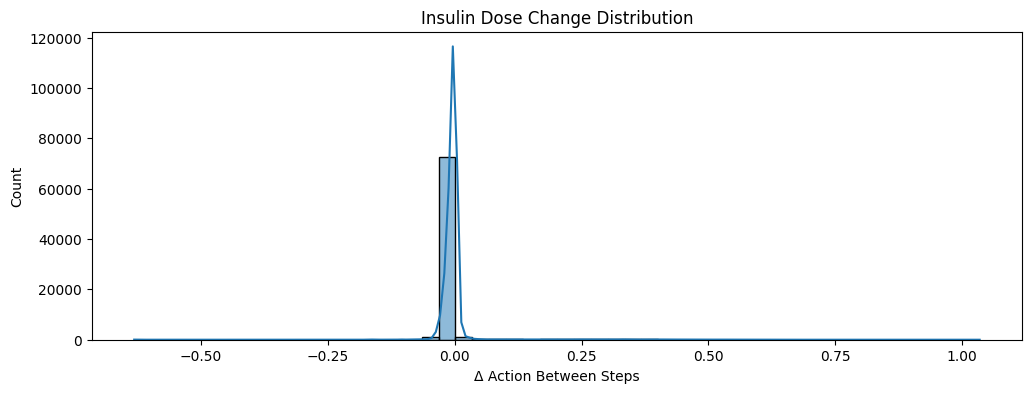


Insulin Change Stats:
Mean Δ: 0.000
Max Increase: 1.034
Max Decrease: -0.631


c:\Users\emili\procoding\Gloop\dataset_analysis.py:205: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  action_heatmap = pd.pivot_table(
c:\Users\emili\procoding\Gloop\dataset_analysis.py:205: FutureWarning: The provided callable <function mean at 0x000002CEC200E980> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  action_heatmap = pd.pivot_table(


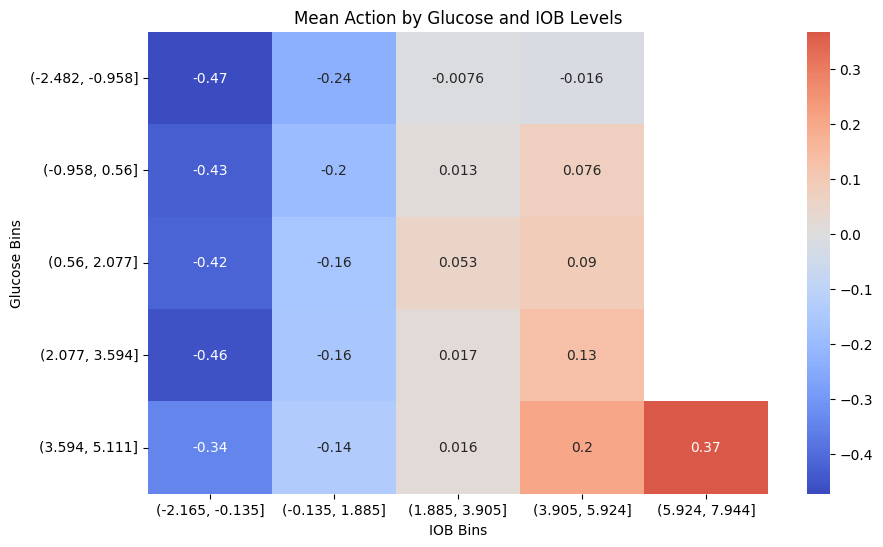


Conservative Actions (Bottom 25%): 21.31%
Action Range Utilization: 71.4% of possible [-1,1] range

Reward Breakdown by Glucose Range:
                      0
Hypoglycemia  -5.000000
Target Range  -0.718688
Hyperglycemia -0.674087

High IOB Actions (Top 25%): Mean=-0.079

Hourly Coverage (% of total):
hour
0.000000    4.166721
0.041667    4.166721
0.083333    4.166721
0.125000    4.166721
0.166667    4.166721
0.208333    4.166721
0.250000    4.166721
0.291667    4.166721
0.333333    4.166721
0.375000    4.166721
0.416667    4.166721
0.458333    4.166721
0.500000    4.166721
0.541667    4.166721
0.583333    4.166721
0.625000    4.166721
0.666667    4.166721
0.708333    4.166721
0.750000    4.166721
0.791667    4.166721
0.833333    4.166721
0.875000    4.166721
0.916667    4.166721
0.958333    4.165416
dtype: float64

Success Rate in Target Range: 35.42%
Average Action in Target Range: -0.318


In [5]:
dataset = DiabetesDataset("datasets/processed/full-training.csv")
evaluate_dataset_coverage(dataset, n_samples=2000)